In this project we will use SQLite and python libraries to analyze the logs of learners' activity on online classes.


## Data description

SQLite database 'logs.db' with a table 'vimbox_pages' containing the following fields:
- user_id \[TEXT\];
- page \[TEXT\];
- happened_at \[DATETIME\].

## Task

Write an SQL query to find all the sessions during which a user was doing the homework before the lesson. I.e. followed a sequence of actions:

*1) 0 or more times visited any page;* <br>
2) visited rooms.homework-showcase (directory with homeworks list);<br>
*3) 0 or more times visited any page;*<br>
4) visited rooms.view.step.content (homework page);<br>
*5) 0 or more times visited any page;*<br>
6) visited rooms.lesson.rev.step.content (page of a lesson with a teacher);<br>
*7) 0 or more times visited any page.*
  
A session is any user activity with less than 1 hour between sequentual actions. It starts at the time of the first action and ends 1 hour after the last.

The result should be an extract containing the following fields:
- user_id;
- session_start_datetime;
- session_end_datetime.

Additionally, make a graph such that it should show typical session length, distribution of the number of sessions by hour and ouliers (non-typical sessions).

## Part 1: Pulling the needed data from the database

Connect to the database:

In [3]:
%%capture
%load_ext sql
%sql sqlite:///logs.db

Extract all the sessions with homework done before a lesson:

In [4]:
%%sql sessions_hw <<
WITH
    t_session_lags as 
    (SELECT *,
          LAG(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS prev_event,
          LEAD(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS next_event
    FROM vimbox_pages),
    
    t_session_markers AS
    (SELECT
        *,
        CASE WHEN prev_event IS NULL OR strftime('%s',happened_at) - strftime('%s',prev_event) >= 60*60 THEN 1 ELSE 0 END session_start_marker,
        CASE WHEN next_event IS NULL OR strftime('%s',next_event) - strftime('%s',happened_at) >= 60*60 THEN 1 ELSE 0 END session_end_marker
    FROM
        t_session_lags
    ORDER BY
        user_id,
        happened_at),
    t_sessions AS
    (SELECT
        *,
        SUM(session_start_marker) OVER (ORDER BY user_id, happened_at rows unbounded preceding) global_session_id,
        SUM(session_start_marker) OVER (PARTITION BY user_id ORDER BY happened_at rows unbounded preceding) user_session_id
    FROM t_session_markers),
    
    session_summary AS
    (SELECT DISTINCT
        user_id,
        global_session_id,
        user_session_id,
        FIRST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following) session_start,
        DATETIME((LAST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following)), '+60 minute') session_end,
        GROUP_CONCAT(page, ' -> ') OVER (PARTITION BY global_session_id order by happened_at rows between unbounded preceding AND unbounded following) session_logs
    FROM t_sessions
    ORDER BY 2,3)    
   
SELECT
    user_id,
    session_start,
    session_end
FROM
    session_summary
where session_logs LIKE '%rooms.homework-showcase%rooms.view.step.content%rooms.lesson.rev.step.content%'
order by user_id, session_start;

 * sqlite:///logs.db
Done.
Returning data to local variable sessions_hw


In [5]:
sessions_hw.DataFrame().head()

,user_id,session_start,session_end
0,10461,2017-03-01 16:45,2017-03-01 18:50:00
1,105503,2017-03-01 09:48,2017-03-01 11:34:00
2,105889,2017-03-01 08:31,2017-03-01 10:51:00
3,107363,2017-03-01 06:15,2017-03-01 08:51:00
4,107383,2017-03-01 15:25,2017-03-01 17:52:00


In [6]:
sessions_hw.DataFrame().shape

(359, 3)

Extract sessions frequency and average lengths by hour:

In [7]:
%%sql sessions_hw_freq <<
WITH
    t_session_lags as 
    (SELECT *,
          LAG(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS prev_event,
          LEAD(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS next_event
    FROM vimbox_pages),
    
    t_session_markers AS
    (SELECT
        *,
        CASE WHEN prev_event IS NULL OR strftime('%s',happened_at) - strftime('%s',prev_event) >= 60*60 THEN 1 ELSE 0 END session_start_marker,
        CASE WHEN next_event IS NULL OR strftime('%s',next_event) - strftime('%s',happened_at) >= 60*60 THEN 1 ELSE 0 END session_end_marker
    FROM
        t_session_lags
    ORDER BY
        user_id,
        happened_at),
    t_sessions AS
    (SELECT
        *,
        SUM(session_start_marker) OVER (ORDER BY user_id, happened_at rows unbounded preceding) global_session_id,
        SUM(session_start_marker) OVER (PARTITION BY user_id ORDER BY happened_at rows unbounded preceding) user_session_id
    FROM t_session_markers),
    
    session_summary AS
    (SELECT DISTINCT
        user_id,
        global_session_id,
        user_session_id,
        FIRST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following) session_start,
        DATETIME((LAST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following)), '+60 minute') session_end,
        GROUP_CONCAT(page, ' -> ') OVER (PARTITION BY global_session_id order by happened_at rows between unbounded preceding AND unbounded following) session_logs
    FROM t_sessions
    ORDER BY 2,3)    
   
SELECT
    strftime('%H',session_start) session_start_hr,
    avg(CAST(strftime('%s',session_end) - strftime('%s',session_start) as float) / 60) avg_length_minutes,
    count(global_session_id) nr_sessions
    
FROM
    session_summary
where session_logs LIKE '%rooms.homework-showcase%rooms.view.step.content%rooms.lesson.rev.step.content%'
group by session_start_hr
order by session_start_hr;

 * sqlite:///logs.db
Done.
Returning data to local variable sessions_hw_freq


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
sessions_hw_freq = sessions_hw_freq.DataFrame()
sessions_hw_freq['session_start_hr'] = sessions_hw_freq['session_start_hr'].astype(int)
sessions_hw_freq['nr_sessions'] = sessions_hw_freq['nr_sessions'].astype(int)

for i in range(24):
    if i not in sessions_hw_freq['session_start_hr'].values:
        df = pd.DataFrame([[i if col == 'session_start_hr' else 0 for col in sessions_hw_freq.columns]],
                        columns = sessions_hw_freq.columns)
        sessions_hw_freq = sessions_hw_freq.append(df, ignore_index=True)
sessions_hw_freq = sessions_hw_freq.sort_values(by = 'session_start_hr')

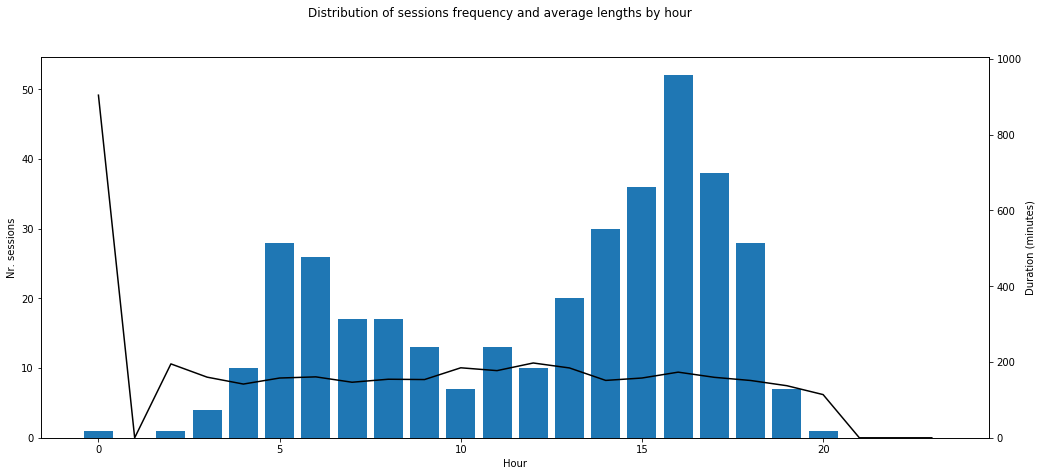

In [10]:
fig,ax = plt.subplots(figsize=(17,7))
ax2 = ax.twinx()
ax.bar(sessions_hw_freq['session_start_hr'],sessions_hw_freq['nr_sessions'])
ax2.plot(sessions_hw_freq['session_start_hr'],sessions_hw_freq['avg_length_minutes'], color = 'black')
ax.set_ylabel('Nr. sessions')
ax2.set_ylabel('Duration (minutes)')
ax2.set_ylim([0,max(sessions_hw_freq['avg_length_minutes'])+100])
ax.set_xlabel('Hour')
fig.suptitle('Distribution of sessions frequency and average lengths by hour')
plt.show()

Calculate sessions duration statistics:

In [11]:
%%sql sessions_hw_stats <<
WITH
    t_session_lags as 
    (SELECT *,
          LAG(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS prev_event,
          LEAD(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS next_event
    FROM vimbox_pages),
    
    t_session_markers AS
    (SELECT
        *,
        CASE WHEN prev_event IS NULL OR strftime('%s',happened_at) - strftime('%s',prev_event) >= 60*60 THEN 1 ELSE 0 END session_start_marker,
        CASE WHEN next_event IS NULL OR strftime('%s',next_event) - strftime('%s',happened_at) >= 60*60 THEN 1 ELSE 0 END session_end_marker
    FROM
        t_session_lags
    ORDER BY
        user_id,
        happened_at),
    t_sessions AS
    (SELECT
        *,
        SUM(session_start_marker) OVER (ORDER BY user_id, happened_at rows unbounded preceding) global_session_id,
        SUM(session_start_marker) OVER (PARTITION BY user_id ORDER BY happened_at rows unbounded preceding) user_session_id
    FROM t_session_markers),
    
    session_summary AS
    (SELECT DISTINCT
        user_id,
        global_session_id,
        user_session_id,
        FIRST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following) session_start,
        DATETIME((LAST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following)), '+60 minute') session_end,
        GROUP_CONCAT(page, ' -> ') OVER (PARTITION BY global_session_id order by happened_at rows between unbounded preceding AND unbounded following) session_logs
    FROM t_sessions
    ORDER BY 2,3),
    
    session_summary_quartiles_helper1 AS
    (SELECT 
        user_id,
        global_session_id,
        user_session_id,
        session_start,
        session_end,
        CAST(strftime('%s',session_end) - strftime('%s',session_start) as float) / 60 session_length_minutes,
        NTILE(4) OVER (ORDER BY CAST(strftime('%s',session_end) - strftime('%s',session_start) as float) / 60) quartile
    FROM
        session_summary
    WHERE
        session_logs LIKE '%rooms.homework-showcase%rooms.view.step.content%rooms.lesson.rev.step.content%'),
        
    session_summary_quartiles_helper2 AS
    (SELECT
        *,
        MAX(session_length_minutes) OVER(PARTITION BY quartile) max_ntile_value,
        CASE WHEN quartile = 1 THEN MAX(session_length_minutes) OVER(PARTITION BY quartile) ELSE NULL END q1_value,
        CASE WHEN quartile = 2 THEN MAX(session_length_minutes) OVER(PARTITION BY quartile) ELSE NULL END q2_value,
        CASE WHEN quartile = 3 THEN MAX(session_length_minutes) OVER(PARTITION BY quartile) ELSE NULL END q3_value
    FROM
        session_summary_quartiles_helper1
    order by session_start),
    
    session_summary_quartiles_helper3 AS
    (SELECT
        user_id,
        session_start,
        session_end,
        session_length_minutes,
        quartile,
        MAX(q1_value) OVER() - (MAX(q3_value) OVER()-MAX(q1_value) OVER())*1.5  lower_whisker_calc,
        MAX(q1_value) OVER() q1,
        MAX(q2_value) OVER() q2,
        MAX(q3_value) OVER() q3,
        MAX(q3_value) OVER() + (MAX(q3_value) OVER()-MAX(q1_value) OVER())*1.5 upper_whisker_calc
    FROM
        session_summary_quartiles_helper2
    order by session_start),
    
    session_summary_quartiles as
    (SELECT
        user_id,
        session_start,
        session_end,
        session_length_minutes,
        quartile,
        MIN(session_length_minutes) OVER() "min",
        MIN(CASE WHEN session_length_minutes > lower_whisker_calc THEN session_length_minutes ELSE NULL END) OVER() lower_whisker,
        q1,
        q2,
        q3,
        MAX(CASE WHEN session_length_minutes < upper_whisker_calc THEN session_length_minutes ELSE NULL END) OVER() upper_whisker,
        MAX(session_length_minutes) OVER() "max"
        
    FROM
        session_summary_quartiles_helper3)
    
SELECT DISTINCT
    AVG(session_length_minutes) OVER() avg_length,
    min,
    lower_whisker,
    q1,
    q2,
    q3,
    upper_whisker,
    max
FROM
    session_summary_quartiles

 * sqlite:///logs.db
Done.
Returning data to local variable sessions_hw_stats


In [12]:
sessions_hw_stats.DataFrame()

,avg_length,min,lower_whisker,q1,q2,q3,upper_whisker,max
0,163.590529,66.0,66.0,131.0,155.0,184.0,263.0,904.0


Find outliers - we will define outliers as the sessions with length outside of \[\(Q1 - 1.5\*IQR); \(Q3 + 1.5\*IQR\)\], where IQR is interquartile range (Q3-Q1):

In [13]:
%%sql sessions_hw_outliers <<
WITH
    t_session_lags as 
    (SELECT *,
          LAG(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS prev_event,
          LEAD(happened_at, 1) OVER (PARTITION BY user_id ORDER BY happened_at) AS next_event
    FROM vimbox_pages),
    
    t_session_markers AS
    (SELECT
        *,
        CASE WHEN prev_event IS NULL OR strftime('%s',happened_at) - strftime('%s',prev_event) >= 60*60 THEN 1 ELSE 0 END session_start_marker,
        CASE WHEN next_event IS NULL OR strftime('%s',next_event) - strftime('%s',happened_at) >= 60*60 THEN 1 ELSE 0 END session_end_marker
    FROM
        t_session_lags
    ORDER BY
        user_id,
        happened_at),
    t_sessions AS
    (SELECT
        *,
        SUM(session_start_marker) OVER (ORDER BY user_id, happened_at rows unbounded preceding) global_session_id,
        SUM(session_start_marker) OVER (PARTITION BY user_id ORDER BY happened_at rows unbounded preceding) user_session_id
    FROM t_session_markers),
    
    session_summary AS
    (SELECT DISTINCT
        user_id,
        global_session_id,
        user_session_id,
        FIRST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following) session_start,
        DATETIME((LAST_VALUE(happened_at) OVER (PARTITION BY global_session_id ORDER BY happened_at rows between unbounded preceding AND unbounded following)), '+60 minute') session_end,
        GROUP_CONCAT(page, ' -> ') OVER (PARTITION BY global_session_id order by happened_at rows between unbounded preceding AND unbounded following) session_logs
    FROM t_sessions
    ORDER BY 2,3),
    
    session_summary_quartiles_helper1 AS
    (SELECT 
        user_id,
        global_session_id,
        user_session_id,
        session_start,
        session_end,
        CAST(strftime('%s',session_end) - strftime('%s',session_start) as float) / 60 session_length_minutes,
        NTILE(4) OVER (ORDER BY CAST(strftime('%s',session_end) - strftime('%s',session_start) as float) / 60) quartile
    FROM
        session_summary
    WHERE
        session_logs LIKE '%rooms.homework-showcase%rooms.view.step.content%rooms.lesson.rev.step.content%'),
        
    session_summary_quartiles_helper2 AS
    (SELECT
        *,
        MAX(session_length_minutes) OVER(PARTITION BY quartile) max_ntile_value,
        CASE WHEN quartile = 1 THEN MAX(session_length_minutes) OVER(PARTITION BY quartile) ELSE NULL END q1_value,
        CASE WHEN quartile = 2 THEN MAX(session_length_minutes) OVER(PARTITION BY quartile) ELSE NULL END q2_value,
        CASE WHEN quartile = 3 THEN MAX(session_length_minutes) OVER(PARTITION BY quartile) ELSE NULL END q3_value
    FROM
        session_summary_quartiles_helper1
    order by session_start),
    
    session_summary_quartiles_helper3 AS
    (SELECT
        user_id,
        session_start,
        session_end,
        session_length_minutes,
        quartile,
        MAX(q1_value) OVER() - (MAX(q3_value) OVER()-MAX(q1_value) OVER())*1.5  lower_whisker_calc,
        MAX(q1_value) OVER() q1,
        MAX(q2_value) OVER() q2,
        MAX(q3_value) OVER() q3,
        MAX(q3_value) OVER() + (MAX(q3_value) OVER()-MAX(q1_value) OVER())*1.5 upper_whisker_calc
    FROM
        session_summary_quartiles_helper2
    order by session_start),
    
    session_summary_quartiles as
    (SELECT
        user_id,
        session_start,
        session_end,
        session_length_minutes,
        quartile,
        MIN(session_length_minutes) OVER() "min",
        MIN(CASE WHEN session_length_minutes > lower_whisker_calc THEN session_length_minutes ELSE NULL END) OVER() lower_whisker,
        q1,
        q2,
        q3,
        MAX(CASE WHEN session_length_minutes < upper_whisker_calc THEN session_length_minutes ELSE NULL END) OVER() upper_whisker,
        MAX(session_length_minutes) OVER() "max"
        
    FROM
        session_summary_quartiles_helper3)
    
SELECT
    user_id,
    session_start,
    session_end,
    session_length_minutes,
    CASE WHEN (session_length_minutes < lower_whisker) THEN 'duration below norm [' || CAST(lower_whisker as TEXT) || '-' || cast(upper_whisker as TEXT) || '] min'
    WHEN (session_length_minutes > upper_whisker) THEN 'duration above norm [' || CAST(lower_whisker as TEXT) || '-' || cast(upper_whisker as TEXT) || '] min'
    ELSE 'duration within norm [' || CAST(lower_whisker as TEXT) || '-' || cast(upper_whisker as TEXT) || '] min' END category
FROM
    session_summary_quartiles
WHERE category NOT LIKE 'duration within norm%'
order by session_length_minutes DESC

 * sqlite:///logs.db
Done.
Returning data to local variable sessions_hw_outliers


In [14]:
sessions_hw_outliers.DataFrame()

,user_id,session_start,session_end,session_length_minutes,category
0,86931,2017-03-01 00:22,2017-03-01 15:26:00,904.0,duration above norm [66.0-263.0] min
1,86931,2017-03-01 16:22,2017-03-02 00:26:00,484.0,duration above norm [66.0-263.0] min
2,167901,2017-03-01 14:56,2017-03-01 20:57:00,361.0,duration above norm [66.0-263.0] min
3,142560,2017-03-01 15:17,2017-03-01 21:18:00,361.0,duration above norm [66.0-263.0] min
4,54640,2017-03-01 05:50,2017-03-01 11:13:00,323.0,duration above norm [66.0-263.0] min
5,213767,2017-03-01 12:59,2017-03-01 17:57:00,298.0,duration above norm [66.0-263.0] min
6,70588,2017-03-01 16:05,2017-03-01 21:00:00,295.0,duration above norm [66.0-263.0] min
7,123474,2017-03-01 13:07,2017-03-01 17:55:00,288.0,duration above norm [66.0-263.0] min
8,198536,2017-03-01 09:07,2017-03-01 13:46:00,279.0,duration above norm [66.0-263.0] min
9,133298,2017-03-01 11:28,2017-03-01 15:58:00,270.0,duration above norm [66.0-263.0] min


## Part 2: Visualization

In [26]:
sessions_hw_df = sessions_hw.DataFrame().copy()

In [29]:
sessions_hw_df = sessions_hw_df.astype({
    "user_id": str,
    "session_start": 'datetime64[ns]',
    "session_end": 'datetime64[ns]'
})

In [70]:
sessions_hw_df['duration_min'] = (sessions_hw_df["session_end"] - sessions_hw_df["session_start"]).dt.total_seconds()/60

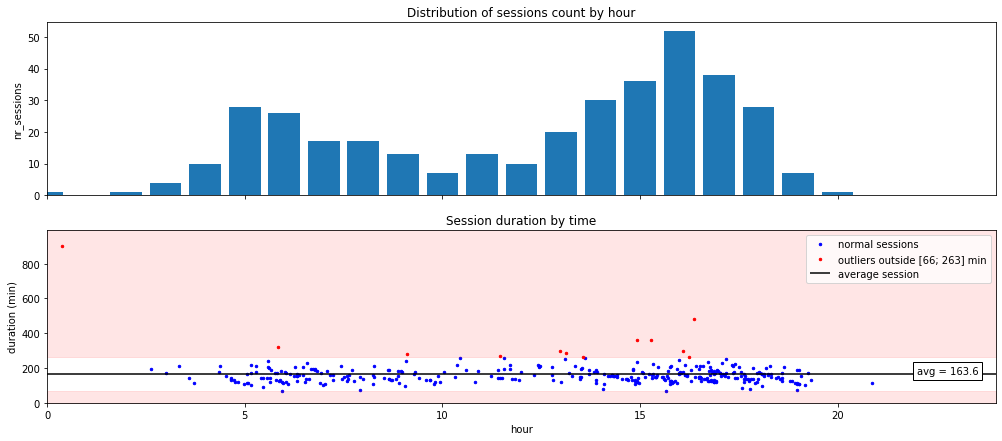

Outliers:


,user_id,session_start,session_end,session_length_minutes,category
0,86931,2017-03-01 00:22,2017-03-01 15:26:00,904.0,duration above norm [66.0-263.0] min
1,86931,2017-03-01 16:22,2017-03-02 00:26:00,484.0,duration above norm [66.0-263.0] min
2,167901,2017-03-01 14:56,2017-03-01 20:57:00,361.0,duration above norm [66.0-263.0] min
3,142560,2017-03-01 15:17,2017-03-01 21:18:00,361.0,duration above norm [66.0-263.0] min
4,54640,2017-03-01 05:50,2017-03-01 11:13:00,323.0,duration above norm [66.0-263.0] min
5,213767,2017-03-01 12:59,2017-03-01 17:57:00,298.0,duration above norm [66.0-263.0] min
6,70588,2017-03-01 16:05,2017-03-01 21:00:00,295.0,duration above norm [66.0-263.0] min
7,123474,2017-03-01 13:07,2017-03-01 17:55:00,288.0,duration above norm [66.0-263.0] min
8,198536,2017-03-01 09:07,2017-03-01 13:46:00,279.0,duration above norm [66.0-263.0] min
9,133298,2017-03-01 11:28,2017-03-01 15:58:00,270.0,duration above norm [66.0-263.0] min


In [153]:
fig, axs = plt.subplots(nrows = 2, figsize = (17,7), sharex = True)
import numpy as np

# plot 1
xx = sessions_hw_df['duration_min'].groupby(sessions_hw_df["session_start"].dt.hour).count()
axs[0].bar(xx.index, xx)
axs[0].set_xlim((0,24))
axs[0].set_title('Distribution of sessions count by hour')
axs[0].set_ylabel('nr_sessions')

# plot 2
x = sessions_hw_df["session_start"].dt.hour + sessions_hw_df["session_start"].dt.minute / 60
filt = (sessions_hw_df['duration_min'] >= sessions_hw_stats.DataFrame()['lower_whisker'].values[0]) & \
(sessions_hw_df['duration_min'] <= sessions_hw_stats.DataFrame()['upper_whisker'].values[0])

axs[1].scatter(x[filt],
               sessions_hw_df['duration_min'][filt],
              s = 6,
              color = 'blue', label ='normal sessions')
axs[1].scatter(x[~filt],
               sessions_hw_df['duration_min'][~filt],
               s = 6,
               color = 'red',
               label = 'outliers outside [{:.0f}; {:.0f}] min'.format(sessions_hw_stats.DataFrame()['lower_whisker'][0],
                                                                              sessions_hw_stats.DataFrame()['upper_whisker'][0]))
axs[1].hlines(sessions_hw_df['duration_min'].mean(), 0, 24, label = 'average session')
axs[1].fill_between(np.arange(0,25,1), sessions_hw_df['duration_min'].max()*1.1,
                    sessions_hw_stats.DataFrame()['upper_whisker'], alpha = 0.1, color = 'red')
axs[1].fill_between(np.arange(0,25,1), sessions_hw_stats.DataFrame()['lower_whisker'],0, alpha = 0.1, color = 'red')

axs[1].text(22, sessions_hw_df['duration_min'].mean(),
            'avg = {:.1f}'.format(sessions_hw_df['duration_min'].mean()), bbox=dict(facecolor='white'))

axs[1].set_ylim(0, sessions_hw_df['duration_min'].max()*1.1)
axs[1].set_ylabel('duration (min)')
axs[1].legend()
axs[1].set_title('Session duration by time')

plt.xlabel('hour')

plt.show()

# outliers
print("Outliers:")
sessions_hw_outliers.DataFrame()